In [1]:
import sys, os

In [2]:
sys.path.extend([os.path.abspath('../../../../')])

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Example of the tangent linear and adjoint models usage

## Preamble

This notebook shows how to use and integrate the tangent linear and ajoint models.

## Reinhold and Pierrehumbert 1982 model version

This notebook use the model version with a simple 2-layer channel QG atmosphere truncated at wavenumber 2 on a beta-plane with a simple orography (a montain and a valley). 

More detail can be found in the articles:

* Reinhold, B. B., & Pierrehumbert, R. T. (1982). *Dynamics of weather regimes: Quasi-stationary waves and blocking*. Monthly Weather Review, **110** (9), 1105-1145. [doi:10.1175/1520-0493(1982)110%3C1105:DOWRQS%3E2.0.CO;2](https://doi.org/10.1175/1520-0493(1982)110%3C1105:DOWRQS%3E2.0.CO;2)
* Cehelsky, P., & Tung, K. K. (1987). *Theories of multiple equilibria and weather regimes—A critical reexamination. Part II: Baroclinic two-layer models*. Journal of the atmospheric sciences, **44** (21), 3282-3303. [doi:10.1175/1520-0469(1987)044%3C3282%3ATOMEAW%3E2.0.CO%3B2](https://doi.org/10.1175/1520-0469(1987)044%3C3282%3ATOMEAW%3E2.0.CO%3B2)


## Modules import

Loading of some modules...

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Initializing the random number generator (for reproducibility). -- Disable if needed.

In [5]:
np.random.seed(210217)

Importing the model's modules

In [6]:
from qgs.params.params import QgParams
from qgs.integrators.integrator import RungeKuttaIntegrator, RungeKuttaTglsIntegrator
from qgs.functions.tendencies import create_tendencies
from qgs.plotting.util import std_plot

## Systems definition

General parameters

In [7]:
# Time parameters
dt = 0.1
# Saving the model state n steps
write_steps = 5

number_of_trajectories = 1
number_of_perturbed_trajectories = 10

Setting some model parameters

In [8]:
# Model parameters instantiation with some non-default specs
model_parameters = QgParams({'phi0_npi': np.deg2rad(50.)/np.pi, 'hd':0.3})
# Mode truncation at the wavenumber 2 in both x and y spatial coordinate
model_parameters.set_atmospheric_modes(2, 2)

# Changing (increasing) the orography depth and the meridional temperature gradient
model_parameters.ground_params.set_orography(0.4, 1)
model_parameters.atemperature_params.set_thetas(0.2, 0)

In [9]:
# Printing the model's parameters
model_parameters.print_params()

Qgs parameters summary

General Parameters:
'time_unit': days,
'rr': 287.058  [J][kg^-1][K^-1]  (gas constant of dry air),
'sb': 5.67e-08  [J][m^-2][s^-1][K^-4]  (Stefan-Boltzmann constant),

Scale Parameters:
'scale': 5000000.0  [m]  (characteristic space scale (L*pi)),
'f0': 0.0001032  [s^-1]  (Coriolis parameter at the middle of the domain),
'n': 1.3    (aspect ratio (n = 2 L_y / L_x)),
'rra': 6370000.0  [m]  (earth radius),
'phi0_npi': 0.2777777777777778    (latitude exprimed in fraction of pi),
'deltap': 50000.0  [Pa]  (pressure difference between the two atmospheric layers),

Atmospheric Parameters:
'kd': 0.1  [nondim]  (atmosphere bottom friction coefficient),
'kdp': 0.01  [nondim]  (atmosphere internal friction coefficient),
'sigma': 0.2  [nondim]  (static stability of the atmosphere),

Atmospheric Temperature Parameters:
'hd': 0.3  [nondim]  (Newtonian cooling coefficient),
'thetas[1]': 0.2    (spectral components 1 of the temperature profile),
'thetas[2]': 0.0    (spectral co

Creating the tendencies function

In [10]:
f, Df = create_tendencies(model_parameters)

## Time integration to obtain an initial condition

Defining an integrator

In [11]:
integrator = RungeKuttaIntegrator()
integrator.set_func(f)

Start on a random initial condition and integrate over a transient time to obtain an initial condition on the attractors

In [12]:
ic = np.random.rand(model_parameters.ndim)*0.1
integrator.integrate(0., 200000., dt, ic=ic, write_steps=0)
time, ic = integrator.get_trajectories()

## Initial condition sensitivity analysis example

Instantiating a tangent linear integrator with the model tendencies and Jacobian matrix

In [13]:
tgls_integrator = RungeKuttaTglsIntegrator()

In [14]:
tgls_integrator.set_func(f, Df)

Integrating with slightly perturbed initial conditions

In [15]:
tangent_ic = 0.0005*np.random.randn(number_of_perturbed_trajectories, model_parameters.ndim)

In [16]:
tgls_integrator.integrate(0., 180., dt=dt, write_steps=write_steps, ic=ic, tg_ic=tangent_ic)

Obtaining the perturbed trajectories

In [17]:
tt, traj, delta = tgls_integrator.get_trajectories()

In [18]:
pert_traj = traj + delta

Trajectories plot

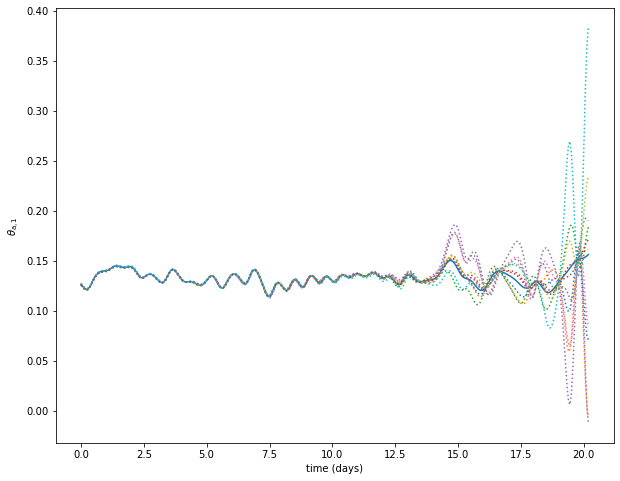

In [19]:
var = 10
plt.figure(figsize=(10, 8))

plt.plot(model_parameters.dimensional_time*tt, traj[var])
plt.plot(model_parameters.dimensional_time*tt, pert_traj[:,var].T, ls=':')

ax = plt.gca()

plt.xlabel('time (days)')
plt.ylabel('$'+model_parameters.latex_var_string[var]+'$');

Mean and standard deviation

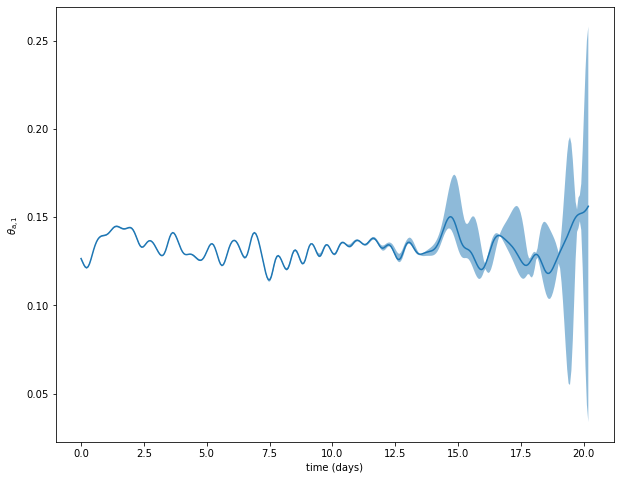

In [20]:
var = 10
plt.figure(figsize=(10, 8))

plt.plot(model_parameters.dimensional_time*tt, traj[var])

ax = plt.gca()
std_plot(model_parameters.dimensional_time*tt, np.mean(pert_traj[:,var], axis=0), np.sqrt(np.var(pert_traj[:, var], axis=0)), ax=ax, alpha=0.5)

plt.xlabel('time (days)')
plt.ylabel('$'+model_parameters.latex_var_string[var]+'$');

## Integrating the adjoint model

Integrating the adjoint model is quite simple and can be done with the same code, simply changing one of the integrator's parameter:

In [21]:
tgls_integrator.integrate(0., 100., dt=dt, write_steps=write_steps, ic=ic, tg_ic=tangent_ic, adjoint=True)

Obtaining the perturbed trajectories

In [22]:
tt, traj, delta = tgls_integrator.get_trajectories()

In [23]:
pert_traj = traj + delta

Trajectories plot

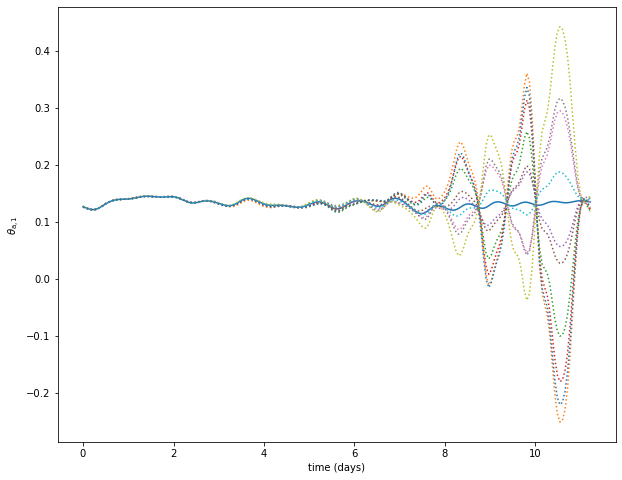

In [24]:
var = 10
plt.figure(figsize=(10, 8))

plt.plot(model_parameters.dimensional_time*tt, traj[var])
plt.plot(model_parameters.dimensional_time*tt, pert_traj[:,var].T, ls=':')

ax = plt.gca()

plt.xlabel('time (days)')
plt.ylabel('$'+model_parameters.latex_var_string[var]+'$');

Mean and standard deviation

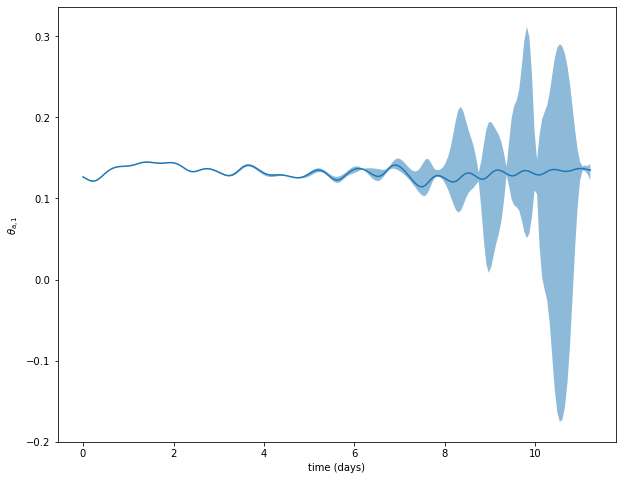

In [25]:
var = 10
plt.figure(figsize=(10, 8))

plt.plot(model_parameters.dimensional_time*tt, traj[var])

ax = plt.gca()
std_plot(model_parameters.dimensional_time*tt, np.mean(pert_traj[:,var], axis=0), np.sqrt(np.var(pert_traj[:, var], axis=0)), ax=ax, alpha=0.5)

plt.xlabel('time (days)')
plt.ylabel('$'+model_parameters.latex_var_string[var]+'$');